In [19]:
import numpy as np 
import torch
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [20]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as datatools

class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(128, 2)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x 

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False 

def plot_training(losses):
    fig, axes = plt.subplots(1,len(losses), sharex=False, sharey=False)
    for i , (key, value) in enumerate(losses.items()):
        x_points = range(0, len(value))
        axes[i].set_title(key, fontsize=10)
        axes[i].plot(x_points, value, color="blue", linewidth=5)
        axes[i].yaxis.grid(True, zorder=0)
        axes[i].set_xlabel('Iteration', fontsize=10)
        # axes[i].legend(loc='upper right')
    # plt.tight_layout()
    plt.show()
    
def train(lstm_model, loader_train, loader_test, n_epochs, early_stopper, device):
    best_model = None
    best_loss = np.inf
    loss_train = []
    loss_validation = []
    for epoch in range(n_epochs):
        lstm_model.train()
        loss_tr =0
        for X_batch, y_batch in loader_train:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = lstm_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_tr += loss.item()
        loss_train.append(loss_tr)
        print('Epoch %s/%s: Train Cross-Entropy: %.6f' % (epoch+1,n_epochs, loss_tr/len(loader_train)))
            
        # Validation
        lstm_model.eval()
        loss= 0
        with torch.no_grad():
            for X_batch_test, y_batch_test in loader_test:
                X_batch_test = X_batch_test.to(device)
                y_batch_test = y_batch_test.to(device)
                y_pred_test = lstm_model(X_batch_test)
                loss += loss_fn(y_pred_test, y_batch_test)
                # print( loss)
                # loss_te += loss
            loss_validation.append(loss.item())
            # if loss < best_loss:
            #     best_loss = loss
            #     best_model = lstm_model.state_dict()
            
            print("Epoch %s/%s: Validation Cross-Entropy: %.6f" % (epoch+1,n_epochs, loss.item()/len(loader_test)))
            if early_stopper.early_stop(loss.item()): 
                best_model = lstm_model.state_dict()            
                break 
    losses = {"train": loss_train, "validation": loss_validation}
    plot_training(losses)
    return best_model, lstm_model, loss_train, loss_validation

In [21]:
device = 'cpu'
gen_dir = 'generated_data/'
models_dir = 'models/' 
results_dir = 'results/'

In [22]:
# Load data
data = np.load('master_data/data.npy')
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
print('Number of training batches: ', train_batches)
print('Length of each batch: ', length)
print('Number of stocks: ', stocks)

Number of training batches:  79
Length of each batch:  256
Number of stocks:  434


In [23]:
vqvaeconv2 = np.load(gen_dir + 'vqvaeconv2.npy')
vqvaeconv2.shape

(434, 256)

In [24]:
# Random batche
# index = np.random.randint(0, train_batches, 1)
index = 77
print('Random batch index: ', index)
batch = data[index,:,:]
batch = np.transpose(batch)
batch = np.squeeze(batch)
batch.shape

Random batch index:  77


(434, 256)

In [25]:
data = np.concatenate((batch, vqvaeconv2), axis=0)
data.shape

(868, 256)

In [26]:
y_batch = np.zeros((batch.shape[0],1), dtype=int)
y_synthetic = np.ones((vqvaeconv2.shape[0],1), dtype=int)
y = np.concatenate((y_batch, y_synthetic), axis=0)
y.shape


(868, 1)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=0.3, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape: ', X_val.shape)
print('y_val shape: ', y_val.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

print('Counts of label')
print('Train: ', np.unique(y_train, return_counts=True))
print('Validation: ', np.unique(y_val, return_counts=True))
print('Test: ', np.unique(y_test, return_counts=True))

X_train shape:  (607, 256)
y_train shape:  (607, 1)
X_val shape:  (130, 256)
y_val shape:  (130, 1)
X_test shape:  (131, 256)
y_test shape:  (131, 1)
Counts of label
Train:  (array([0, 1]), array([306, 301]))
Validation:  (array([0, 1]), array([64, 66]))
Test:  (array([0, 1]), array([64, 67]))


In [28]:
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, length, 1)
y_train = torch.tensor(y_train).reshape(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, length, 1)
y_val = torch.tensor(y_val).reshape(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, length, 1)
y_test = torch.tensor(y_test).reshape(-1)

In [29]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(torch.Size([607, 256, 1]),
 torch.Size([607]),
 torch.Size([130, 256, 1]),
 torch.Size([130]),
 torch.Size([131, 256, 1]),
 torch.Size([131]))

Epoch 1/70: Train Cross-Entropy: 42.108650
Epoch 1/70: Validation Cross-Entropy: 30.037392
Epoch 2/70: Train Cross-Entropy: 42.056247
Epoch 2/70: Validation Cross-Entropy: 30.076113
Epoch 3/70: Train Cross-Entropy: 42.136926
Epoch 3/70: Validation Cross-Entropy: 30.037905
Epoch 4/70: Train Cross-Entropy: 42.076285
Epoch 4/70: Validation Cross-Entropy: 30.048149
Epoch 5/70: Train Cross-Entropy: 42.119127
Epoch 5/70: Validation Cross-Entropy: 30.043938
Epoch 6/70: Train Cross-Entropy: 42.038600
Epoch 6/70: Validation Cross-Entropy: 30.031713
Epoch 7/70: Train Cross-Entropy: 42.064383
Epoch 7/70: Validation Cross-Entropy: 30.044408
Epoch 8/70: Train Cross-Entropy: 42.154708
Epoch 8/70: Validation Cross-Entropy: 30.034091
Epoch 9/70: Train Cross-Entropy: 42.087946
Epoch 9/70: Validation Cross-Entropy: 30.038961
Epoch 10/70: Train Cross-Entropy: 42.059367
Epoch 10/70: Validation Cross-Entropy: 30.055476
Epoch 11/70: Train Cross-Entropy: 42.084155
Epoch 11/70: Validation Cross-Entropy: 30.04

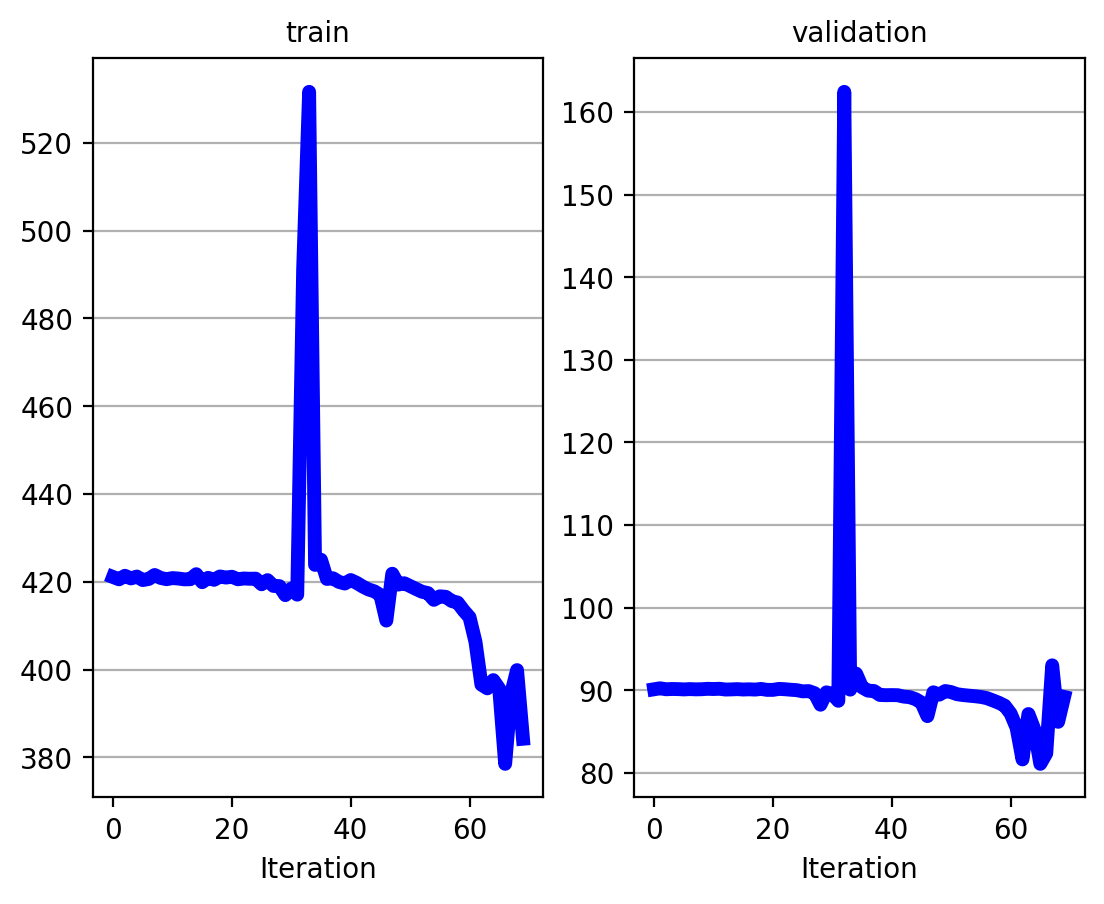

In [37]:
device = 'mps'
n_epochs = 70
batch_size = 64
learning_rate = 0.001
lstm_model = LSTM_Model().to(device)
early_stopper = EarlyStopper(patience=10, min_delta=10)
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(reduction="sum")
loader_train = datatools.DataLoader(datatools.TensorDataset(X_train, y_train ), shuffle=True, batch_size=batch_size)
loader_test = datatools.DataLoader(datatools.TensorDataset(X_val, y_val), shuffle=False, batch_size=batch_size)
best_model, lstm_model, loss_train, loss_validation = train(lstm_model, loader_train, loader_test, n_epochs, early_stopper, device)
torch.save(best_model, models_dir+"best_classification_lstm.pth")

# Testing 

In [38]:


x_test = X_test.to(device)
y_pred = lstm_model(x_test)
y_pred = y_pred.argmax(dim=1)
y_pred = y_pred.cpu().numpy()
print(f'Accuracy score: ')
print(accuracy_score(y_test, y_pred))
print('')
print(f'ROC AUC score: ')
print(roc_auc_score(y_test, y_pred))
# print('')
# print(f'Confusion matrix {key}: ')
# print(confusion_matrix(y_test, y_pred))
print('')
print(f'Classification report: ')
print(classification_report(y_test, y_pred))

Accuracy score: 
0.6030534351145038

ROC AUC score: 
0.5989972014925373

Classification report: 
              precision    recall  f1-score   support

           0       0.64      0.42      0.51        64
           1       0.58      0.78      0.67        67

    accuracy                           0.60       131
   macro avg       0.61      0.60      0.59       131
weighted avg       0.61      0.60      0.59       131

